##### Objective : Predict purchased or not using decision tree model

In [1514]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [1515]:
dataframe = pd.read_csv('E:\Data Science\Python\machine learning exercise\dataset\Social_Network_Ads.csv')

In [1516]:
dataframe.drop(columns='User ID', axis=1, inplace=True)

In [1517]:
dataframe

,Gender,Age,EstimatedSalary,Purchased
0,Male,19,19000,0
1,Male,35,20000,0
2,Female,26,43000,0
3,Female,27,57000,0
4,Male,19,76000,0
...,...,...,...,...
395,Female,46,41000,1
396,Male,51,23000,1
397,Female,50,20000,1
398,Male,36,33000,0


<AxesSubplot: >

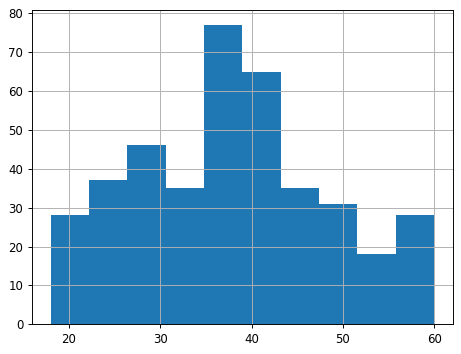

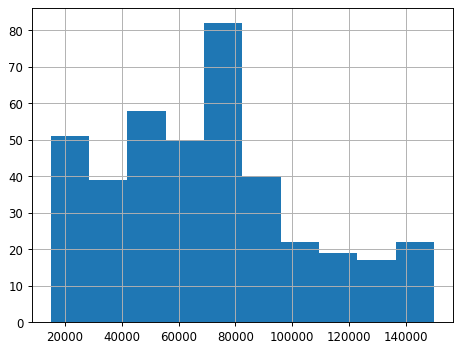

In [1518]:
plt.figure()
dataframe['Age'].hist()
plt.figure()
dataframe['EstimatedSalary'].hist()

<AxesSubplot: >

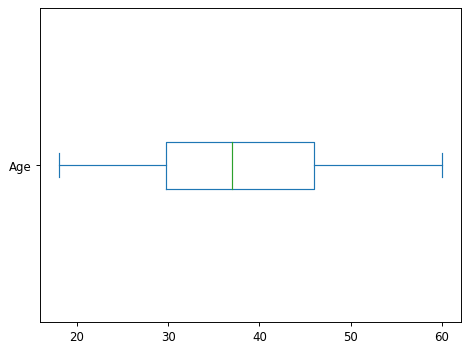

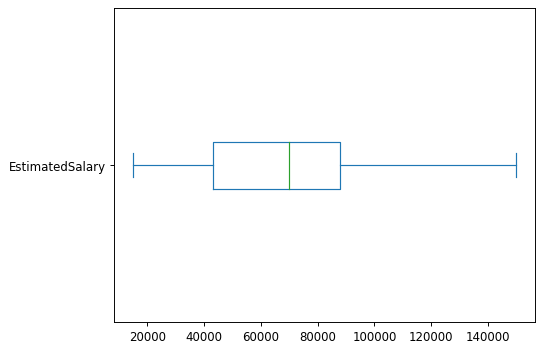

In [1519]:
plt.figure()
dataframe['Age'].plot(kind='box', vert=False)
plt.figure()
dataframe['EstimatedSalary'].plot(kind='box', vert=False)

In [1520]:
dataframe.replace({'Female':0, 'Male':1}).corr()['Purchased']

Gender            -0.042469
Age                0.622454
EstimatedSalary    0.362083
Purchased          1.000000
Name: Purchased, dtype: float64

In [1521]:
# Calculate WoE and IV
def woe_iv_values(dataframe:pd.DataFrame, feature:str, target:str):
    
    dataframe = pd.concat([dataframe.groupby(feature)[target].sum().reset_index(), dataframe.groupby(feature)[target].count().reset_index()], axis=1)
    dataframe = dataframe.iloc[:, [0,1, 3]]
    dataframe.columns = [dataframe.columns.values[0], 'n_good', 'n_observation']

    dataframe['n_bad'] = dataframe['n_observation'] - dataframe['n_good']
    dataframe['bad-rate_pct'] = round((dataframe['n_bad'] / dataframe['n_observation']) * 100, 3)
    dataframe['good_proportion'] = dataframe['n_good'] / dataframe['n_good'].sum()
    dataframe['bad_proportion'] = dataframe['n_bad'] / dataframe['n_bad'].sum()
    dataframe['WoE'] = np.log(dataframe['good_proportion'] / dataframe['bad_proportion'])
    dataframe['IV'] = (dataframe['good_proportion'] - dataframe['bad_proportion'] * dataframe['WoE']).sum()

    return dataframe

In [1522]:
# IV values = 1 means the feature is to good to be true, we can drop it or we can use it depends on business intuition
woe_iv_values(dataframe=dataframe, feature='Gender', target='Purchased')

,Gender,n_good,n_observation,n_bad,bad-rate_pct,good_proportion,bad_proportion,WoE,IV
0,Female,77,204,127,62.255,0.538462,0.494163,0.085850,1.003935
1,Male,66,196,130,66.327,0.461538,0.505837,-0.091648,1.003935


In [1523]:
X = dataframe.drop(columns='Purchased', axis=1)
y = dataframe.Purchased

In [1524]:
X['Gender'] = X['Gender'].replace({'Female':0, 'Male':1})

In [1525]:
# Calculate mutual information
# Mutual information = 0 means, there is no relationship between predictor and target variables
mutual_info_classif(X, y)

array([0.02242457, 0.22574413, 0.10043914])

In [1526]:
X.drop('Gender', axis=1, inplace=True)

In [1527]:
y.value_counts()

0    257
1    143
Name: Purchased, dtype: int64

In [1528]:
# Imbalance target prediction
'Target proportion : ', y.value_counts().values[0]/y.shape * 100, y.value_counts().values[1]/y.shape * 100

('Target proportion : ', array([64.25]), array([35.75]))

In [1529]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11, test_size=0.3, stratify=y)

In [1530]:
# Scaling, MinMax scaler
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scale = scaler.fit_transform(X_train)
y_train_scale = y_train
X_test_scale = scaler.fit_transform(X_test)
y_test_scale = y_test

# Scaling X for cross validation check
scaler2 = MinMaxScaler()
scaler2.fit(X)

X_scale = scaler2.fit_transform(X)

In [1531]:
# Handle imbalance target prediction for unscaled data
smote  = SMOTE(random_state=11)
smote.fit(X_train, y_train)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Handle imbalance target prediction for scaled data
smote2 = SMOTE(random_state=11)
smote2.fit(X_train_scale, y_train_scale)
X_train_scale, y_train_scale = smote2.fit_resample(X_train_scale, y_train_scale)

In [1532]:
# Original dataset
X, y.value_counts()

(     Age  EstimatedSalary
 0     19            19000
 1     35            20000
 2     26            43000
 3     27            57000
 4     19            76000
 ..   ...              ...
 395   46            41000
 396   51            23000
 397   50            20000
 398   36            33000
 399   49            36000
 
 [400 rows x 2 columns],
 0    257
 1    143
 Name: Purchased, dtype: int64)

In [1533]:
# Dataset for cross validation model, with scaling 
X_scale[:10], y.value_counts()

(array([[0.02380952, 0.02962963],
        [0.4047619 , 0.03703704],
        [0.19047619, 0.20740741],
        [0.21428571, 0.31111111],
        [0.02380952, 0.45185185],
        [0.21428571, 0.31851852],
        [0.21428571, 0.51111111],
        [0.33333333, 1.        ],
        [0.16666667, 0.13333333],
        [0.4047619 , 0.37037037]]),
 0    257
 1    143
 Name: Purchased, dtype: int64)

In [1534]:
# Data train without scaling
X_train, y_train.value_counts()

(     Age  EstimatedSalary
 0     48            74000
 1     53           143000
 2     47            23000
 3     33           149000
 4     37            77000
 ..   ...              ...
 355   45            76797
 356   58            45911
 357   40           136753
 358   35           146713
 359   45            74152
 
 [360 rows x 2 columns],
 1    180
 0    180
 Name: Purchased, dtype: int64)

In [1535]:
# Data train with scaling
X_train_scale[:10], y_train_scale.value_counts()

(array([[0.71428571, 0.43703704],
        [0.83333333, 0.94814815],
        [0.69047619, 0.05925926],
        [0.35714286, 0.99259259],
        [0.45238095, 0.45925926],
        [0.52380952, 0.34074074],
        [0.4047619 , 0.25925926],
        [0.85714286, 0.08148148],
        [0.11904762, 0.03703704],
        [0.73809524, 0.54814815]]),
 1    180
 0    180
 Name: Purchased, dtype: int64)

### Machine learning model 'Decision Tree' without scaling

In [1536]:
model = DecisionTreeClassifier()
model.fit(X=X_train, y=y_train)
print('Train accuracy : ', model.score(X_train, y_train))
print('Test accuracy : ', model.score(X_test, y_test))
# K-Fold cross validation
print('Cross validation score accuracy : ', cross_val_score(model, X, y, cv=4).mean(), end='\n\n')

y_pred = model.predict(X_test)

report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)

Train accuracy :  0.9972222222222222
Test accuracy :  0.8916666666666667
Cross validation score accuracy :  0.8250000000000002

              precision    recall  f1-score   support

           0       0.92      0.91      0.92        77
           1       0.84      0.86      0.85        43

    accuracy                           0.89       120
   macro avg       0.88      0.88      0.88       120
weighted avg       0.89      0.89      0.89       120



In [1537]:
# Display decision tree 
# plt.rcParams['figure.dpi'] = 85
# plt.subplots(figsize=(25, 10))
# tree.plot_tree(model, fontsize=10)
# plt.show()

#### Hyperparameter tunnning

In [1538]:
param_grid = {'max_depth': [3, 4, 5, 6, 7, 8],
              'min_samples_split': [2, 3, 4, 5, 6],
              'criterion': ['gini', 'entropy']}
grid_search = GridSearchCV(model, param_grid=param_grid, cv=4, scoring='accuracy')

grid_search.fit(X_train, y_train)

y_train_pred = grid_search.predict(X_train)
train_accuracy = accuracy_score(y_true=y_train, y_pred=y_train_pred)

y_test_pred = grid_search.predict(X_test)
test_accuracy =  accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('Train accuracy :', train_accuracy)
print('Test accuracy :', test_accuracy)
print('Best param :', grid_search.best_params_, end='\n\n')

tun_report = classification_report(y_true=y_test, y_pred=y_test_pred)
print(tun_report)

Train accuracy : 0.9305555555555556
Test accuracy : 0.8666666666666667
Best param : {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}

              precision    recall  f1-score   support

           0       0.94      0.84      0.89        77
           1       0.76      0.91      0.83        43

    accuracy                           0.87       120
   macro avg       0.85      0.88      0.86       120
weighted avg       0.88      0.87      0.87       120



### Machine learning model 'Decision Tree' with scaling

In [1539]:
model2 = DecisionTreeClassifier()
model2.fit(X=X_train_scale, y=y_train_scale)
print('Train accuracy : ', model2.score(X_train_scale, y_train_scale))
print('Test accuracy : ', model2.score(X_test_scale, y_test_scale))
# K-Fold cross validation
print('Cross validation score accuracy : ', cross_val_score(model2, X_scale, y, cv=4).mean(), end='\n\n')

y_pred2 = model2.predict(X_test_scale)

report2 = classification_report(y_true=y_test_scale, y_pred=y_pred2)
print(report2)

Train accuracy :  0.9972222222222222
Test accuracy :  0.85
Cross validation score accuracy :  0.8200000000000001

              precision    recall  f1-score   support

           0       0.87      0.90      0.88        77
           1       0.80      0.77      0.79        43

    accuracy                           0.85       120
   macro avg       0.84      0.83      0.84       120
weighted avg       0.85      0.85      0.85       120



In [1540]:
# Display decision tree
# plt.rcParams['figure.dpi'] = 85
# plt.subplots(figsize=(25, 10))
# tree.plot_tree(model2, fontsize=10)
# plt.show()

#### Hyperparameter tunning

In [1541]:
param_grid = {'max_depth': [3, 4, 5, 6, 7, 8],
              'min_samples_split': [2, 3, 4, 5, 6],
              'criterion': ['gini', 'entropy']}
grid_search = GridSearchCV(model2, param_grid=param_grid, cv=4, scoring='accuracy')

grid_search.fit(X_train_scale, y_train_scale)

y_train_pred2 = grid_search.predict(X_train_scale)
train_accuracy = accuracy_score(y_true=y_train_scale, y_pred=y_train_pred2)

y_test_pred2 = grid_search.predict(X_test_scale)
test_accuracy =  accuracy_score(y_true=y_test_scale, y_pred=y_test_pred2)

print('Train accuracy :', train_accuracy)
print('Test accuracy :', test_accuracy)
print('Best param :', grid_search.best_params_, end='\n\n')

tun_report2 = classification_report(y_true=y_test, y_pred=y_test_pred2)
print(tun_report2)

Train accuracy : 0.9527777777777777
Test accuracy : 0.8583333333333333
Best param : {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 6}

              precision    recall  f1-score   support

           0       0.89      0.88      0.89        77
           1       0.80      0.81      0.80        43

    accuracy                           0.86       120
   macro avg       0.85      0.85      0.85       120
weighted avg       0.86      0.86      0.86       120



"The decision tree algorithm model without feature scaling and with hyperparameter tuning showed the best performance with an accuracy of 93.0% on the training data and 86.6% on the testing data. Other decision tree models resulted in overfitting, with a significant difference between the accuracy of the training and testing data."